In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from load import rematch_sets, rematch_cand

plt.style.use('ggplot')

### Load the refined dataset
To replicate this notebook, download the original DIME dataset and run the python file **load.py** included in this repo. For a step-by-step guide to data processing run in **load.py**, look through the data_cleaning notebook. Essential details will be repeated here, so it is not necessary to read that notebook first. 

In [2]:
cand_df = pd.read_csv('data/candidate_df.csv')

#### For simplicity, we'll only include columns needed for initial exploration. 

In [3]:
col_short_list = ['cycle', 'Cand.ID', 'ICPSR', 'name','party', 'state', 'district', 
                  'Incum.Chall', 'total.disbursements', 'total.receipts',
                  'gen.elect.pct', 'winner', 'race_ID']
len(col_short_list)

13

|       Column Name      |         Column Description                                                       |
|:----------------------:|:---------------------------------:                                               |
| Cycle                  | Election year                                                                    |
| Cand.ID                | Identification for Candidate                                                     |
| ICPSR                  | Unique identifier specific to candidate AND election                             |
| name                   | Name of candidate                                                                |
| party                  | Political Party: 100 = Dem, 200 = Rep, 328 = Ind                                 |
| state                  | Two-letter state abbreviations                                                   |
| district               | District code: two-letter state code followed by congressional district number.  |
| Incum.Chall            | Incumbency status: ’I’ = Incumbent, ’C’ = Challenger, ’O’ = Open Seat Candidate  |
| total.disbursements    | Campaign funds spent                                                             |
| total.receipts         | Campaign funds received                                                          |
| gen.elect.pct          | FEC reported vote share in general election                                      |
| winner                 | General election outcome: 'L' or 'W'                                             |
| race_ID                | Election Year + District code                                                    |

In [4]:
cand_df = cand_df[col_short_list]

In [5]:
print(cand_df.shape)
cand_df.head(3)

(13531, 13)


,cycle,Cand.ID,ICPSR,name,party,state,district,Incum.Chall,total.disbursements,total.receipts,gen.elect.pct,winner,race_ID
0,1980.0,H8WV03014,148651980,"staton, david michael ""mick""",200,WV,WV03,C,73025.0,70755.0,53.0,W,1980-WV03
1,1980.0,H8WI07013,H8WI070131980,"vesta, vinton a.",200,WI,WI07,C,29971.0,30162.0,35.0,L,1980-WI07
2,1980.0,H8WI04028,H8WI040281980,"honadel, elroy charles",200,WI,WI04,C,10201.0,9720.0,29.0,L,1980-WI04


In [106]:
eda = cand_df.copy()
eda.rename(columns={'party':'Party','Incum.Chall':'Incumbency','total.disbursements':'Money Spent','total.receipts':'Money Received','gen.elect.pct':'Vote Percentage','winner':'Election Results'},inplace=True)


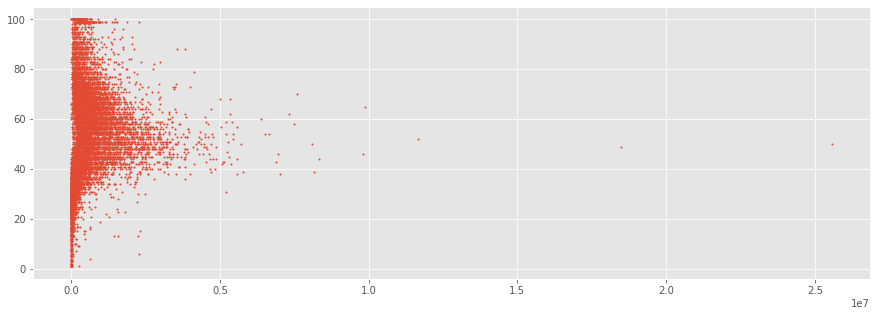

In [107]:
X = eda['Money Spent']
y = eda['Vote Percentage']
plt.subplots(figsize = (15, 5))
plt.scatter(X, y, s=2)
plt.show()

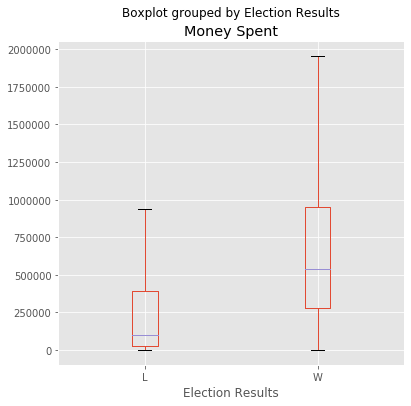

In [116]:
fig, ax = plt.subplots(1, figsize=(6,6))
eda.boxplot(ax=ax, column=['Money Spent'], by='Election Results', showfliers=False)
plt.show()

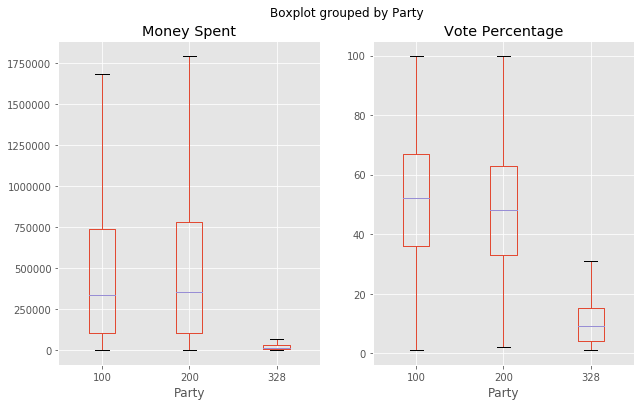

In [122]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
eda.boxplot(ax=ax[0], column=['Money Spent'], by='Party', showfliers=False)
eda.boxplot(ax=ax[1], column=['Vote Percentage'], by='Party', showfliers=False)

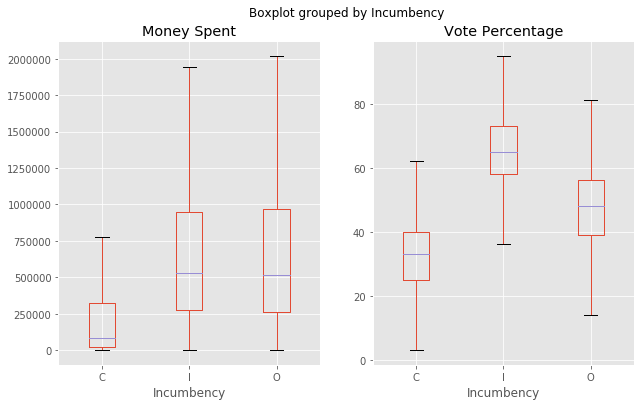

In [123]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
eda.boxplot(ax=ax[0], column=['Money Spent'], by='Incumbency', showfliers=False)
eda.boxplot(ax=ax[1], column=['Vote Percentage'], by='Incumbency', showfliers=False)
plt.show()

### Remember the research question: 
In congressional rematch elections, is there a correlation between changes in campaign expenditures and changes in vote percentage? 

#### Defining 'rematch'
For clarity, we'll think of rematches as two elections that have the same two leading candidates. When we look at the change in campaign spending and votes received, we will evaluate the races chronologically. 

#### Designing the dataframe
We currently have one row per candidate per election. We want one row per rematch, which includes candidate A, candidate B, first race, and second race. 

In [7]:
match_one = [x[0] for x in rematch_sets]
match_two = [x[1] for x in rematch_sets]

In [8]:
match1_df = cand_df[cand_df['race_ID'].isin(match_one)].copy()
match2_df = cand_df[cand_df['race_ID'].isin(match_two)].copy()

In [9]:
rematch_cand_A = [each[0] for each in rematch_cand if len(each)==2]
rematch_cand_B = [each[1] for each in rematch_cand if len(each)==2]

In [10]:
match_1A = match1_df[match1_df['ICPSR'].isin(rematch_cand_A)].copy()
match_1B = match1_df[match1_df['ICPSR'].isin(rematch_cand_B)].copy()

In [11]:
match_2A = match2_df[match2_df['ICPSR'].isin(rematch_cand_A)].copy()
match_2B = match2_df[match2_df['ICPSR'].isin(rematch_cand_B)].copy()

In [12]:
columns_list = list(match_1A.columns)
columns_list

['cycle',
 'Cand.ID',
 'ICPSR',
 'name',
 'party',
 'state',
 'district',
 'Incum.Chall',
 'total.disbursements',
 'total.receipts',
 'gen.elect.pct',
 'winner',
 'race_ID']

In [13]:
column_dictA1 = {'Cand.ID': 'A1_id', 'district.partisanship': 'DP1', 'ICPSR': 'A_ICPSR', 'name':'A1_name', 'party':'A1_party', 'Incum.Chall':'A1_IC', 'state':'state1', 'district':'district1', 'total.disbursements':'A1_spent', 'total.receipts':'A1_raised', 'gen.elect.pct':'A1_pct', 'winner':'A1_outcome', 'race_ID':'race1_ID'}
column_dictB1 = {'Cand.ID': 'B1_id', 'district.partisanship': 'DP1', 'ICPSR': 'B_ICPSR', 'name':'B1_name', 'party':'B1_party', 'Incum.Chall':'B1_IC', 'state':'state1', 'district':'district1', 'total.disbursements':'B1_spent', 'total.receipts':'B1_raised', 'gen.elect.pct':'B1_pct', 'winner':'B1_outcome', 'race_ID':'race1_ID'}
column_dictA2 = {'Cand.ID': 'A2_id', 'district.partisanship': 'DP2', 'ICPSR': 'A_ICPSR', 'name':'A2_name', 'party':'A2_party', 'Incum.Chall':'A2_IC', 'state':'state2', 'district':'district2', 'total.disbursements':'A2_spent', 'total.receipts':'A2_raised', 'gen.elect.pct':'A2_pct', 'winner':'A2_outcome', 'race_ID':'race2_ID'}
column_dictB2 = {'Cand.ID': 'B2_id', 'district.partisanship': 'DP2', 'ICPSR': 'B_ICPSR', 'name':'B2_name', 'party':'B2_party', 'Incum.Chall':'B2_IC', 'state':'state2', 'district':'district2', 'total.disbursements':'B2_spent', 'total.receipts':'B2_raised', 'gen.elect.pct':'B2_pct', 'winner':'B2_outcome', 'race_ID':'race2_ID'}

In [14]:
match_1A.rename(column_dictA1, axis='columns', inplace=True)
match_1A.drop('cycle', axis=1, inplace=True)
match_2A.rename(column_dictA2, axis='columns', inplace=True)
match_2A.drop('cycle', axis=1, inplace=True)
match_1B.rename(column_dictB1, axis='columns', inplace=True)
match_1B.drop(['cycle', 'state1', 'district1'], axis=1, inplace=True)
match_2B.rename(column_dictB2, axis='columns', inplace=True)
match_2B.drop(['cycle', 'state2', 'district2'], axis=1, inplace=True)

In [15]:
first_match_df = match_1A.merge(match_1B)
second_match_df = match_2A.merge(match_2B)

In [16]:
col_order_1 = first_match_df.columns.tolist()
col_order_1.remove('state1')
col_order_1.remove('district1')
col_order_1.remove('race1_ID')
col_order_1.insert(0, 'race1_ID')
col_order_1.insert(1, 'state1')
col_order_1.insert(1, 'district1')

col_order_2 = second_match_df.columns.tolist()
col_order_2.remove('state2')
col_order_2.remove('district2')
col_order_2.remove('race2_ID')
col_order_2.insert(0, 'race2_ID')
col_order_2.insert(1, 'state2')
col_order_2.insert(1, 'district2')

In [17]:
first_match_df = first_match_df.reindex(columns=col_order_1)
second_match_df = second_match_df.reindex(columns=col_order_2)

In [18]:
first_match_df['top_cands'] = first_match_df.agg(lambda x: f"{x['A1_id']}-{x['B1_id']}", axis=1)
first_match_df.head()

,race1_ID,district1,state1,A1_id,A_ICPSR,A1_name,A1_party,A1_IC,A1_spent,A1_raised,...,B1_id,B_ICPSR,B1_name,B1_party,B1_IC,B1_spent,B1_raised,B1_pct,B1_outcome,top_cands
0,1980-TX21,TX21,TX,H8TX21067,146451980,"loeffler, tom",200,I,330566.0,479486.0,...,H6TX21095,H6TX210951980,"sullivan, joseph pierre",100,C,45382.0,45382.0,23.0,L,H8TX21067-H6TX21095
1,1980-NE02,NE02,NE,H8NE02022,148101980,"daub, harold john jr (hal)",200,O,329671.0,331903.0,...,H0NE02052,H0NE020521980,"fellman, richard m",100,O,153539.0,164860.0,44.0,L,H8NE02022-H0NE02052
2,1980-TX13,TX13,TX,H6TX13027,142341980,"hightower, jack",100,I,145292.0,129293.0,...,H0TX13012,H0TX130121980,"slover, ronald edward",200,C,68268.0,74715.0,45.0,L,H6TX13027-H0TX13012
3,1980-NM01,NM01,NM,H6NM01020,120221980,"lujan, manuel jr",200,I,178309.0,185664.0,...,H0NM01015,150551980,"richardson, william b",100,C,234737.0,237013.0,49.0,L,H6NM01020-H0NM01015
4,1980-MD02,MD02,MD,H6MD02039,106011980,"long, clarence dickinson",100,I,153619.0,158280.0,...,H0MD02057,150861980,"bentley, helen delich",200,C,252599.0,253028.0,43.0,L,H6MD02039-H0MD02057


In [19]:
second_match_df['top_cands'] = second_match_df.agg(lambda x: f"{x['A2_id']}-{x['B2_id']}", axis=1)
second_match_df.head()

,race2_ID,district2,state2,A2_id,A_ICPSR,A2_name,A2_party,A2_IC,A2_spent,A2_raised,...,B2_id,B_ICPSR,B2_name,B2_party,B2_IC,B2_spent,B2_raised,B2_pct,B2_outcome,top_cands
0,1982-NE02,NE02,NE,H8NE02022,148101982,"daub, hal",200,I,224139.0,226583.0,...,H0NE02052,H0NE020521982,"fellman, richard m",100,C,160320.0,160320.0,43.0,L,H8NE02022-H0NE02052
1,1982-TX13,TX13,TX,H6TX13027,142341982,"hightower, jack",100,I,325997.0,335506.0,...,H0TX13012,H0TX130121982,"slover, ronald edward",200,C,82625.0,95154.0,35.0,L,H6TX13027-H0TX13012
2,1982-MD02,MD02,MD,H6MD02039,106011982,"long, clarence dickinson",100,I,162439.0,186959.0,...,H0MD02057,150861982,"bentley, helen delich",200,C,209059.0,210254.0,47.0,L,H6MD02039-H0MD02057
3,1982-IL04,IL04,IL,H6IL17049,140411982,"o'brien, george m",200,I,309393.0,293839.0,...,H0IL17018,H0IL170181982,"murer, michael a",100,C,85546.0,83735.0,45.0,L,H6IL17049-H0IL17018
4,1982-CT04,CT04,CT,H6CT04028,130291982,"mckinney, stewart b",200,I,294317.0,301747.0,...,H0CT04039,H0CT040391982,"phillips, john aristotle",100,C,157953.0,156783.0,43.0,L,H6CT04028-H0CT04039


In [20]:
full_df = first_match_df.merge(second_match_df, on='top_cands')

In [21]:
print(full_df.shape)
full_df.head()

(585, 43)


,race1_ID,district1,state1,A1_id,A_ICPSR_x,A1_name,A1_party,A1_IC,A1_spent,A1_raised,...,A2_outcome,B2_id,B_ICPSR_y,B2_name,B2_party,B2_IC,B2_spent,B2_raised,B2_pct,B2_outcome
0,1980-TX21,TX21,TX,H8TX21067,146451980,"loeffler, tom",200,I,330566.0,479486.0,...,W,H6TX21095,H6TX210951984,"sullivan, joe",100,C,4245.0,4245.0,19.0,L
1,1980-NE02,NE02,NE,H8NE02022,148101980,"daub, harold john jr (hal)",200,O,329671.0,331903.0,...,W,H0NE02052,H0NE020521982,"fellman, richard m",100,C,160320.0,160320.0,43.0,L
2,1980-TX13,TX13,TX,H6TX13027,142341980,"hightower, jack",100,I,145292.0,129293.0,...,W,H0TX13012,H0TX130121982,"slover, ronald edward",200,C,82625.0,95154.0,35.0,L
3,1980-NM01,NM01,NM,H6NM01020,120221980,"lujan, manuel jr",200,I,178309.0,185664.0,...,W,H0NM01015,150551984,"richardson, william b",100,I,425934.0,439746.0,60.0,W
4,1980-MD02,MD02,MD,H6MD02039,106011980,"long, clarence dickinson",100,I,153619.0,158280.0,...,W,H0MD02057,150861982,"bentley, helen delich",200,C,209059.0,210254.0,47.0,L


In [22]:
full_order = full_df.columns.tolist()
seven_col = ['top_cands', 'race1_ID', 'race2_ID', 'state1', 'state2', 'district1', 'district2']
for each in seven_col:
    full_order.remove(each)
new_order = seven_col + full_order

In [23]:
full_df = full_df.reindex(columns=new_order)
print(full_df.shape)
full_df.head()

(585, 43)


,top_cands,race1_ID,race2_ID,state1,state2,district1,district2,A1_id,A_ICPSR_x,A1_name,...,A2_outcome,B2_id,B_ICPSR_y,B2_name,B2_party,B2_IC,B2_spent,B2_raised,B2_pct,B2_outcome
0,H8TX21067-H6TX21095,1980-TX21,1984-TX21,TX,TX,TX21,TX21,H8TX21067,146451980,"loeffler, tom",...,W,H6TX21095,H6TX210951984,"sullivan, joe",100,C,4245.0,4245.0,19.0,L
1,H8NE02022-H0NE02052,1980-NE02,1982-NE02,NE,NE,NE02,NE02,H8NE02022,148101980,"daub, harold john jr (hal)",...,W,H0NE02052,H0NE020521982,"fellman, richard m",100,C,160320.0,160320.0,43.0,L
2,H6TX13027-H0TX13012,1980-TX13,1982-TX13,TX,TX,TX13,TX13,H6TX13027,142341980,"hightower, jack",...,W,H0TX13012,H0TX130121982,"slover, ronald edward",200,C,82625.0,95154.0,35.0,L
3,H6NM01020-H0NM01015,1980-NM01,1984-NM01,NM,NM,NM01,NM01,H6NM01020,120221980,"lujan, manuel jr",...,W,H0NM01015,150551984,"richardson, william b",100,I,425934.0,439746.0,60.0,W
4,H6MD02039-H0MD02057,1980-MD02,1982-MD02,MD,MD,MD02,MD02,H6MD02039,106011980,"long, clarence dickinson",...,W,H0MD02057,150861982,"bentley, helen delich",200,C,209059.0,210254.0,47.0,L


### Check for any rematches that don't occur in the same state

Check whether the first race and the second race have the same value in the 'STATE' column. 

In [24]:
full_df[full_df.state1 == full_df.state2].top_cands.count()

585

### Check for any rematches that don't occur in the same district

Check whether the first race and the second race have the same value in the 'DISTRICT' column. 

In [25]:
full_df[full_df.district1 == full_df.district2].top_cands.count()
### Exclude rematches if the two races didn't occur in the same district
full_df = full_df[full_df.district1 == full_df.district2]

### Check how often the 'Challenger' candidate lost the first race

In [26]:
print(full_df[full_df.B1_IC == 'C'].top_cands.count())
### Exclude rematches if the Challenger won; that would make 
full_df = full_df[full_df.B1_IC == 'C']

493


### Check how often the losing candidate switched parties after the election
(I also checked the winning candidates, but there weren't any party switches)

In [27]:
print(full_df[full_df.A2_party == full_df.A1_party].top_cands.count())
print(full_df[full_df.B2_party == full_df.B1_party].top_cands.count())
full_df = full_df[full_df.B2_party == full_df.B1_party]

493
479


#### Party switches
Independent to Republican: 9 // Independent to Democrat: 2 // Republican to Independent: 3

#### Side note : Here's a quick demo of why we didn't use candidate names to find rematches

In [28]:
name_mismatch = full_df[full_df.B2_name != full_df.B1_name][['B1_name', 'B2_name']]
name_mismatch.rename(columns={ 'B1_name':'Name recorded for 1st election' , 'B2_name':'Name recorded for 2nd election' }, inplace=True)
name_mismatch.head(10)

,Name recorded for 1st election,Name recorded for 2nd election
0,"sullivan, joseph pierre","sullivan, joe"
8,"trimarco, thomas m","trimarco, thomas h"
14,"sherck, james robert","sherck, james r"
16,"bagnal, anne","bagnal, anne broyles"
17,"white, william e","white, william ephriam"
18,"carlson, gerald russell","carlson, gerald r"
19,"watson, mark temple","watson, mark"
22,"kennedy, william j","kennedy, bill"
30,"maxwell, dr. allen b.","maxwell, allen b"
38,"buchanan, john morton","buchanan, john m"


In [29]:
full_df.columns

Index(['top_cands', 'race1_ID', 'race2_ID', 'state1', 'state2', 'district1',
       'district2', 'A1_id', 'A_ICPSR_x', 'A1_name', 'A1_party', 'A1_IC',
       'A1_spent', 'A1_raised', 'A1_pct', 'A1_outcome', 'B1_id', 'B_ICPSR_x',
       'B1_name', 'B1_party', 'B1_IC', 'B1_spent', 'B1_raised', 'B1_pct',
       'B1_outcome', 'A2_id', 'A_ICPSR_y', 'A2_name', 'A2_party', 'A2_IC',
       'A2_spent', 'A2_raised', 'A2_pct', 'A2_outcome', 'B2_id', 'B_ICPSR_y',
       'B2_name', 'B2_party', 'B2_IC', 'B2_spent', 'B2_raised', 'B2_pct',
       'B2_outcome'],
      dtype='object')

In [30]:
# full_df.drop(['state2', 'B_ICPSR_y', 'A_ICPSR_y'], axis=1, inplace=True)
col_rename = {'state1':'state', 'B_ICPSR_x':'B_ICPSR', 'A_ICPSR_x':'A_ICPSR'}
full_df.rename(col_rename, axis='columns', inplace=True)

In [31]:
print(full_df.shape)
full_df.head()

(479, 43)


,top_cands,race1_ID,race2_ID,state,state2,district1,district2,A1_id,A_ICPSR,A1_name,...,A2_outcome,B2_id,B_ICPSR_y,B2_name,B2_party,B2_IC,B2_spent,B2_raised,B2_pct,B2_outcome
0,H8TX21067-H6TX21095,1980-TX21,1984-TX21,TX,TX,TX21,TX21,H8TX21067,146451980,"loeffler, tom",...,W,H6TX21095,H6TX210951984,"sullivan, joe",100,C,4245.0,4245.0,19.0,L
2,H6TX13027-H0TX13012,1980-TX13,1982-TX13,TX,TX,TX13,TX13,H6TX13027,142341980,"hightower, jack",...,W,H0TX13012,H0TX130121982,"slover, ronald edward",200,C,82625.0,95154.0,35.0,L
3,H6NM01020-H0NM01015,1980-NM01,1984-NM01,NM,NM,NM01,NM01,H6NM01020,120221980,"lujan, manuel jr",...,W,H0NM01015,150551984,"richardson, william b",100,I,425934.0,439746.0,60.0,W
4,H6MD02039-H0MD02057,1980-MD02,1982-MD02,MD,MD,MD02,MD02,H6MD02039,106011980,"long, clarence dickinson",...,W,H0MD02057,150861982,"bentley, helen delich",200,C,209059.0,210254.0,47.0,L
6,H6CT04028-H0CT04039,1980-CT04,1982-CT04,CT,CT,CT04,CT04,H6CT04028,130291980,"mckinney, stewart b.",...,W,H0CT04039,H0CT040391982,"phillips, john aristotle",100,C,157953.0,156783.0,43.0,L


In [32]:
full_df.dropna(axis=0, inplace=True)

In [33]:
full_df['delta_A%'] = full_df.A2_pct - full_df.A1_pct
full_df['delta_B%'] = full_df.B2_pct - full_df.B1_pct
full_df['delta_A$'] = full_df.A2_spent - full_df.A1_spent
full_df['delta_B$'] = full_df.B2_spent - full_df.B1_spent
full_df['delta_A$%'] = (full_df.A2_spent - full_df.A1_spent)/full_df.A1_spent
full_df['delta_B$%'] = (full_df.B2_spent - full_df.B1_spent)/full_df.B1_spent

In [34]:
full_df[['delta_A%', 'delta_A$','delta_A$%', 'delta_B%', 'delta_B$', 'delta_B$%']].head()

,delta_A%,delta_A$,delta_A$%,delta_B%,delta_B$,delta_B$%
0,3.0,118954.0,0.359849,-4.0,-41137.0,-0.906461
2,9.0,180705.0,1.243737,-10.0,14357.0,0.210304
3,13.0,319716.0,1.793045,11.0,191197.0,0.814516
4,-4.0,8820.0,0.057415,4.0,-43540.0,-0.172368
6,-7.0,74134.0,0.336693,6.0,2322.0,0.014920


### Challenger 

In [35]:
plot_B = full_df[['delta_B%', 'delta_B$', 'delta_B$%']]
plot_B = plot_B.replace([np.inf, -np.inf], np.nan).dropna()

Bx = plot_B['delta_B%'].values.reshape(-1, 1)
By = plot_B['delta_B$'].values.reshape(-1, 1)

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
def plot_line(coef, intercept, x):
    return (coef*x + intercept)

In [38]:
lr = LinearRegression()
reg_B = lr.fit(By, Bx)

In [39]:
coef_B = reg_B.coef_[0][0]
intercept_B = reg_B.intercept_[0]

print('R^2 Score: ', reg_B.score(By,Bx))
print('Slope: ', coef_B)
print('Intercept: ', intercept_B)

R^2 Score:  0.0037044736327059846
Slope:  9.51602523495621e-07
Intercept:  -0.6642705109203743


(-20, 20)

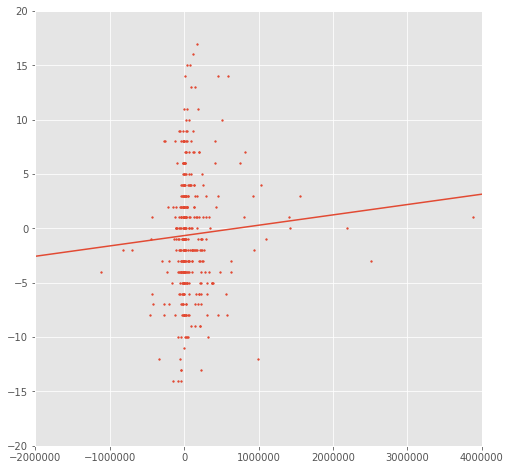

In [40]:
fig, ax = plt.subplots(1, figsize=(8,8))
z = np.linspace(-4000000, 4000000, num=1200)
ax.plot(z, plot_line(coef_B, intercept_B, z), '-')
ax.scatter(By, Bx, alpha=1, s=3)
ax.set_xlim(-2000000, 4000000)
ax.set_ylim(-20, 20)

### Evaluate by Party

In [41]:
GOP_vote = full_df[full_df.B1_party == 200]['delta_B%'].values.reshape(-1,1)
GOP_spend = full_df[full_df.B1_party == 200]['delta_B$'].values.reshape(-1,1)
Dem_vote = full_df[full_df.B1_party == 100]['delta_B%'].values.reshape(-1,1)
Dem_spend = full_df[full_df.B1_party == 100]['delta_B$'].values.reshape(-1,1)
Ind_vote = full_df[full_df.B1_party == 328]['delta_B%'].values.reshape(-1,1)
Ind_spend = full_df[full_df.B1_party == 328]['delta_B$'].values.reshape(-1,1)

In [42]:
### Check count of challengers running as independents
len(Ind_vote)

2

In [43]:
lr = LinearRegression()
reg_GOP = lr.fit(GOP_spend, GOP_vote)

In [44]:
coef_GOP = reg_GOP.coef_[0][0]
intercept_GOP = reg_GOP.intercept_[0]

print('R^2 Score: ', reg_GOP.score(GOP_spend, GOP_vote))
print('Slope: ', coef_GOP)
print('Intercept: ', intercept_GOP)

R^2 Score:  0.0065156919288350545
Slope:  1.3977724081964062e-06
Intercept:  -0.7669595016617103


In [45]:
lr = LinearRegression()
reg_Dem = lr.fit(Dem_spend, Dem_vote)

coef_Dem = reg_Dem.coef_[0][0]
intercept_Dem = reg_Dem.intercept_[0]

print('R^2 Score: ', reg_Dem.score(Dem_spend, Dem_vote))
print('Slope: ', coef_Dem)
print('Intercept: ', intercept_Dem)

R^2 Score:  0.0016341941852479058
Slope:  5.409011258773935e-07
Intercept:  -0.6235482267375181


(-20, 20)

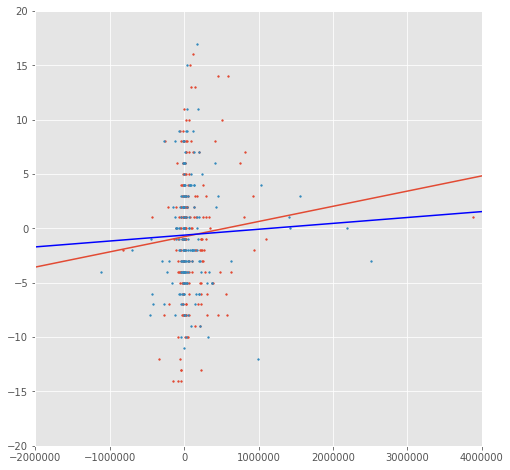

In [46]:
fig, ax = plt.subplots(1, figsize=(8,8))
z = np.linspace(-6000000, 6000000, num=1200)
ax.plot(z, plot_line(coef_GOP, intercept_GOP, z), '-')
ax.scatter(GOP_spend, GOP_vote, alpha=1, s=3)
ax.set_xlim(-4000000, 4000000)
ax.set_ylim(-80, 80)

ax.plot(z, plot_line(coef_Dem, intercept_Dem, z), '-', color='blue')
ax.scatter(Dem_spend, Dem_vote, alpha=1, s=3)
ax.set_xlim(-2000000, 4000000)
ax.set_ylim(-20, 20)